In [ ]:
import numpy as np
import random
import time

# from IPython.display import clear_output
from collections import deque

import matplotlib.pyplot as plt
import gym

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Embedding, Reshape
from tensorflow.keras.optimizers import Adam

In [ ]:

env_name = 'LunarLander-v2'
# env_name = 'CarRacing-v0'
env = gym.make(env_name)

print('Number of states: {}'.format(env.observation_space.shape))
print('Number of actions: {}'.format(env.action_space.n))

Number of states: (8,)
Number of actions: 4


In [ ]:
class ReplayBuffer:
    def __init__(self, maxlen):
        self.buffer = deque(maxlen=maxlen)  #number of experiences to store 
        
    def add(self, experience):
        self.buffer.append(experience)
        
    def sample(self, batch_size):
        sample_size = min(len(self.buffer), batch_size)
        samples = random.choices(self.buffer, k=sample_size)
        return map(list, zip(*samples))

In [ ]:
#Modified Source: https://rubikscode.net/2019/07/08/deep-q-learning-with-python-and-tensorflow-2-0/
'''
DQAgent 
Builds an AI agent using a DQN. Initialized with a gamma value, epsilon value, a minimum value for epsilon, 
an environment, an optimizer, input dimensions, and the sizes for the 2 fully connected layers of the model. 

Methods: 
store: If an episode is terminated, the epsilon value is reduced by the decay rate. 
This pushes the agent from exploration to exploitation as the agent learns. 
Also stores the episodes in the replay buffer using the add method of the ReplayBuffer class. 

build_dqn: Builds a Sequental model with 3 Dense layers. The input layersize is 
the shape of the observation space of the environment. The output layer is the number 
of available actions. The fc1 and fc2 input are the dimensions of the input and hidden layer. 

align_target_model: Initializes the target network with the same weights as the 
initial q_network. 

act: Gets the action the agent will take based on the state, the max value of 
the available actions, and the epsilon greedy method. The action returns a random action 
with the probability of epsilon. 

retrain: Updates the q_network using random samples from the stored episodes in 
the ReplayBuffer, and based on the Bellman equation, using the target 
network to stabilize the learning. 

'''
class DQAgent: 
    def __init__(self, gamma, epsilon, eps_min, environment, optimizer, input_dims, fc1, fc2):
        #initialize state and action space based on environment object
        self.state_size = env.observation_space.shape[0]
        self.action_size = environment.action_space.n
        self.optimizer = optimizer
        self.gamma = gamma
        self.epsilon = epsilon
        self.eps_min = eps_min
        
        #initilize the replay memory
        self.replay_buffer = ReplayBuffer(maxlen=10000)   
      
        #build the Q Network and Target network
        self.q_network = self.build_dqn(self.action_size, input_dims, fc1, fc2)
        self.target_network = self.build_dqn(self.action_size, input_dims, fc1, fc2)
        
        #align the weights
        self.align_target_model() 
        
    #append experience to experience memory        
    def store(self, state, action, reward, next_state, terminated):
        if terminated:
            self.epsilon = max(eps_min, 0.99 * self
                               .epsilon)
        self.replay_buffer.add((state, action, reward, next_state, (1-int(terminated))))


    #Build deep q network 
    def build_dqn(self, n_actions, input_dims, fc1, fc2): #fc = fully connected dimensions
        model = keras.Sequential([
            keras.layers.Dense(fc1, input_shape = input_dims, activation='relu'),             
            keras.layers.Dense(fc2, activation='relu'), 
            keras.layers.Dense(n_actions, activation=None), #output layer, n_actions is number of available actions
        ])

        model.compile(loss='mse', optimizer = self.optimizer)
        return model

    def align_target_model(self):
        self.target_network.set_weights(
            self.q_network.get_weights()) #passes q_network weights to target model

    #exploration vs. exploitation with probability of epsilon
    def act(self, state):        
        state = np.array([state])
        q_values = self.q_network.predict(state)
        action_greedy = np.argmax(q_values[0])
        action_random = np.random.randint(self.action_size)
        action = action_random if random.random() < self.epsilon else action_greedy

        return action


    #take random samples from experience replay memory and train the q_network
    def retrain(self, batch_size):

        states, actions,rewards, next_states,terms = self.replay_buffer.sample(batch_size)
    
        states = np.array(states)
        next_states = np.array(next_states)
        
        q_network = self.q_network.predict(states)
        q_next = self.q_network.predict(next_states)

        q_target = np.copy(q_network)
        batch_index = np.arange(len(q_target), dtype=np.int32)

        
        q_target[batch_index, actions] = rewards + self.gamma * np.ndarray.max(q_next, axis=1) * terms
        
        self.q_network.train_on_batch(states,q_target)
                
        

In [ ]:
env_name = 'LunarLander-v2'
env = gym.make(env_name)
env = gym.wrappers.Monitor(env, "./vid3", video_callable=lambda episode_id: episode_id%10==0)
'''
Hyperparameters are all here so I can tune them all in the same spot

Learning rate
gamma
epsilon
optimizer
Dense layer shape
'''
lr = 0.0005
gam = 0.99
eps = 1.0
eps_min = 0.01
opt = Adam(learning_rate=lr)
dims = env.observation_space.shape
layer_1 = 64
layer_2 = 64

agent = DQAgent(gamma = gam, epsilon = eps, eps_min = eps_min, environment = env, optimizer = opt, 
                input_dims = dims, fc1 = layer_1, fc2 = layer_2)


In [ ]:
batch_size = 64
num_episodes = 500
total_rewards = []
start_time = time.time()
for e in range(num_episodes): 
    #reset the environment to get random initial state
    state = env.reset()
   
    total_reward = 0
    terminated = False
    
    while not terminated:
        env.render()
        action = agent.act(state)      

        # take action 
        next_state, reward, terminated, info = env.step(action)

        # train = store experience in buffer, get samples
        total_reward += reward
        
        agent.store(state, action, reward, next_state, terminated) #add experience to buffer         
        state = next_state
        agent.retrain(batch_size)
    total_rewards.append(total_reward)       
    print("Episode: {}, total reward: {}, epsilon: {}".format(e,total_reward, agent.epsilon))

print("Total time: %s hours" % ((time.time() - start_time)/3600))  
    
    
x = [i for i in range(num_episodes)]

env.close()



Episode: 0, total reward: -226.36609264855755, epsilon: 0.99
Episode: 1, total reward: -81.98728626732843, epsilon: 0.9801
Episode: 2, total reward: -117.4186861323085, epsilon: 0.9702989999999999
Episode: 3, total reward: -133.33822860907006, epsilon: 0.96059601
Episode: 4, total reward: -327.9103678243599, epsilon: 0.9509900498999999
Episode: 5, total reward: -222.56930181799123, epsilon: 0.9414801494009999
Episode: 6, total reward: -343.95747213187025, epsilon: 0.9320653479069899
Episode: 7, total reward: -286.9153056897922, epsilon: 0.92274469442792
Episode: 8, total reward: -49.20342806855217, epsilon: 0.9135172474836407
Episode: 9, total reward: -248.01033789253708, epsilon: 0.9043820750088043
Episode: 10, total reward: -569.171130442405, epsilon: 0.8953382542587163
Episode: 11, total reward: -254.03479465729066, epsilon: 0.8863848717161291
Episode: 12, total reward: -93.23258253563475, epsilon: 0.8775210229989678
Episode: 13, total reward: -68.28920633598548, epsilon: 0.86874581

Episode: 110, total reward: -87.4041391660984, epsilon: 0.3277227574378037
Episode: 111, total reward: -71.28160014527535, epsilon: 0.3244455298634257
Episode: 112, total reward: -268.3117262713881, epsilon: 0.3212010745647914
Episode: 113, total reward: -362.2802803949803, epsilon: 0.3179890638191435
Episode: 114, total reward: -98.07712995736352, epsilon: 0.31480917318095203
Episode: 115, total reward: -45.70460038191196, epsilon: 0.3116610814491425
Episode: 116, total reward: -123.9494324681768, epsilon: 0.30854447063465107
Episode: 117, total reward: -44.00181044447298, epsilon: 0.30545902592830454
Episode: 118, total reward: -85.92313886391764, epsilon: 0.3024044356690215
Episode: 119, total reward: -198.81197243957348, epsilon: 0.29938039131233124
Episode: 120, total reward: 46.50128827240191, epsilon: 0.2963865873992079
Episode: 121, total reward: 105.0175640030955, epsilon: 0.29342272152521587
Episode: 122, total reward: 20.489661228247698, epsilon: 0.2904884943099637
Episode: 

Episode: 218, total reward: 7.608399092131052, epsilon: 0.11068980359934164
Episode: 219, total reward: 9.441399455469607, epsilon: 0.10958290556334822
Episode: 220, total reward: 228.08485524851255, epsilon: 0.10848707650771475
Episode: 221, total reward: 184.97304286518482, epsilon: 0.1074022057426376
Episode: 222, total reward: -33.42620646626666, epsilon: 0.10632818368521123
Episode: 223, total reward: 247.45138395289567, epsilon: 0.10526490184835911
Episode: 224, total reward: 238.5149393314798, epsilon: 0.10421225282987552
Episode: 225, total reward: 291.284175119692, epsilon: 0.10317013030157676
Episode: 226, total reward: 11.974402545361315, epsilon: 0.10213842899856099
Episode: 227, total reward: -65.0167375349999, epsilon: 0.10111704470857538
Episode: 228, total reward: 273.2766359306104, epsilon: 0.10010587426148963
Episode: 229, total reward: 31.994697279113964, epsilon: 0.09910481551887473
Episode: 230, total reward: -155.7337588470827, epsilon: 0.09811376736368599
Episode

Episode: 325, total reward: 285.69064872889254, epsilon: 0.03776360434375024
Episode: 326, total reward: 245.47866483161712, epsilon: 0.03738596830031274
Episode: 327, total reward: -193.17826148343084, epsilon: 0.03701210861730961
Episode: 328, total reward: 254.51806415809892, epsilon: 0.03664198753113651
Episode: 329, total reward: 245.28194749597887, epsilon: 0.036275567655825146
Episode: 330, total reward: 263.8804541747042, epsilon: 0.03591281197926689
Episode: 331, total reward: 279.5238759069143, epsilon: 0.035553683859474224
Episode: 332, total reward: 221.56892562029572, epsilon: 0.03519814702087948
Episode: 333, total reward: 279.31252943836625, epsilon: 0.03484616555067068
Episode: 334, total reward: 237.04890622768855, epsilon: 0.034497703895163975
Episode: 335, total reward: 286.46936207158956, epsilon: 0.03415272685621234
Episode: 336, total reward: 260.6107296260254, epsilon: 0.03381119958765021
Episode: 337, total reward: 279.39177479547845, epsilon: 0.0334730875917737

Episode: 432, total reward: 292.83711632650284, epsilon: 0.012883660162531854
Episode: 433, total reward: 235.3314071483988, epsilon: 0.012754823560906535
Episode: 434, total reward: 256.2395448559487, epsilon: 0.01262727532529747
Episode: 435, total reward: 251.65002897333684, epsilon: 0.012501002572044496
Episode: 436, total reward: 282.5867519373984, epsilon: 0.01237599254632405
Episode: 437, total reward: 247.78149511912275, epsilon: 0.01225223262086081
Episode: 438, total reward: 260.1196458917367, epsilon: 0.012129710294652202
Episode: 439, total reward: 260.84514256821717, epsilon: 0.01200841319170568
Episode: 440, total reward: 208.89856569659375, epsilon: 0.011888329059788623
Episode: 441, total reward: 251.1282091477819, epsilon: 0.011769445769190737
Episode: 442, total reward: 277.4974222767653, epsilon: 0.01165175131149883
Episode: 443, total reward: 279.4277164707501, epsilon: 0.011535233798383842
Episode: 444, total reward: -229.0454436448509, epsilon: 0.01141988146040000

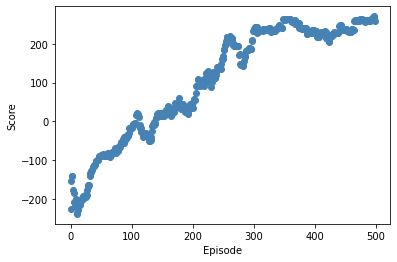

In [ ]:
N = len(total_rewards)
running_avg = np.empty(N)
for t in range(N):
    running_avg[t] = np.mean(total_rewards[max(0, t-20):(t+1)])
plt.xlabel('Episode')
plt.ylabel('Score')
plt.scatter(x, running_avg, color="steelblue");